In [0]:
!nvidia-smi

Wed Aug  7 19:49:43 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    15W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
DRIVE_URL=f"/content/drive/My Drive/gsoc_images"

In [0]:
%cd {DRIVE_URL}
!cp images.zip /content/images.zip
!cp rkd_cnn_train.csv /content/rkd_cnn_train.csv
%cd /content/

/content/drive/My Drive/gsoc_images
/content


In [0]:
!unzip -q images.zip

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [0]:
np.random.seed(2)

In [0]:
import re
def preprocess_df(df, offset):
    def extract(s):
        arr = p.split(s)
        q = s[:2]
        l = 0
        for idx,k in enumerate([arr[2],arr[4], arr[6]]):
            if k is not None:
                if idx == 0:
                    if len(k) >= 2 and k[0] == k[1]:
                        k = k[0]+k[2:]
                    x = k[:offset]
                    q += x
                    l += len(x)
                elif l + 1 <= offset:
                    q += k
                    l += 1
                elif l + 2 <= offset:
                    q += k
                    l += 1
        return q
    
    p = re.compile(r"(\d{1,2})([A-Z]{1,2}\d{0,})?(\(...\))?(\(([A-Z\ ]+)\))?(\((\+\d+)\))?")
    df['IC1'] = pd.Series(
        map(lambda x: ",".join(set(map(lambda y: extract(y.strip()), x))),
            df['Iconclass'].str.split(",")))
    df['IMG'] = df["Id"].astype(str).__add__(".jpg")
    return df

In [0]:
df = preprocess_df(pd.read_csv("rkd_cnn_train.csv"), offset=3)
#df = pd.read_csv("rkd_cnn_train.csv")

In [0]:
PATH = f"./images"

In [0]:
df[:20]

,Id,Iconclass,Valid,IC1,IMG
0,5463,"73B81(+3),73B8",False,"73B81,73B8",5463.jpg
1,37696,"73D721,73D723,73D81",False,"73D81,73D72",37696.jpg
2,216270,73D641(+5),False,73D64,216270.jpg
3,255017,73D231,True,73D23,255017.jpg
4,52981,73D722,False,73D72,52981.jpg
5,43348,73D41,False,73D41,43348.jpg
6,54943,73B57,False,73B57,54943.jpg
7,21060,73DD61,False,73D61,21060.jpg
8,53252,73D15,False,73D15,53252.jpg
9,266022,73E5,True,73E5,266022.jpg


In [0]:
src = ImageList.from_df(df[['IMG','IC1','Valid']],PATH).split_from_df().label_from_df(label_delim=',')

In [0]:
data = src.transform(get_transforms(max_rotate=2.0,max_warp=0.0), size=128).databunch(bs=256).normalize(imagenet_stats)

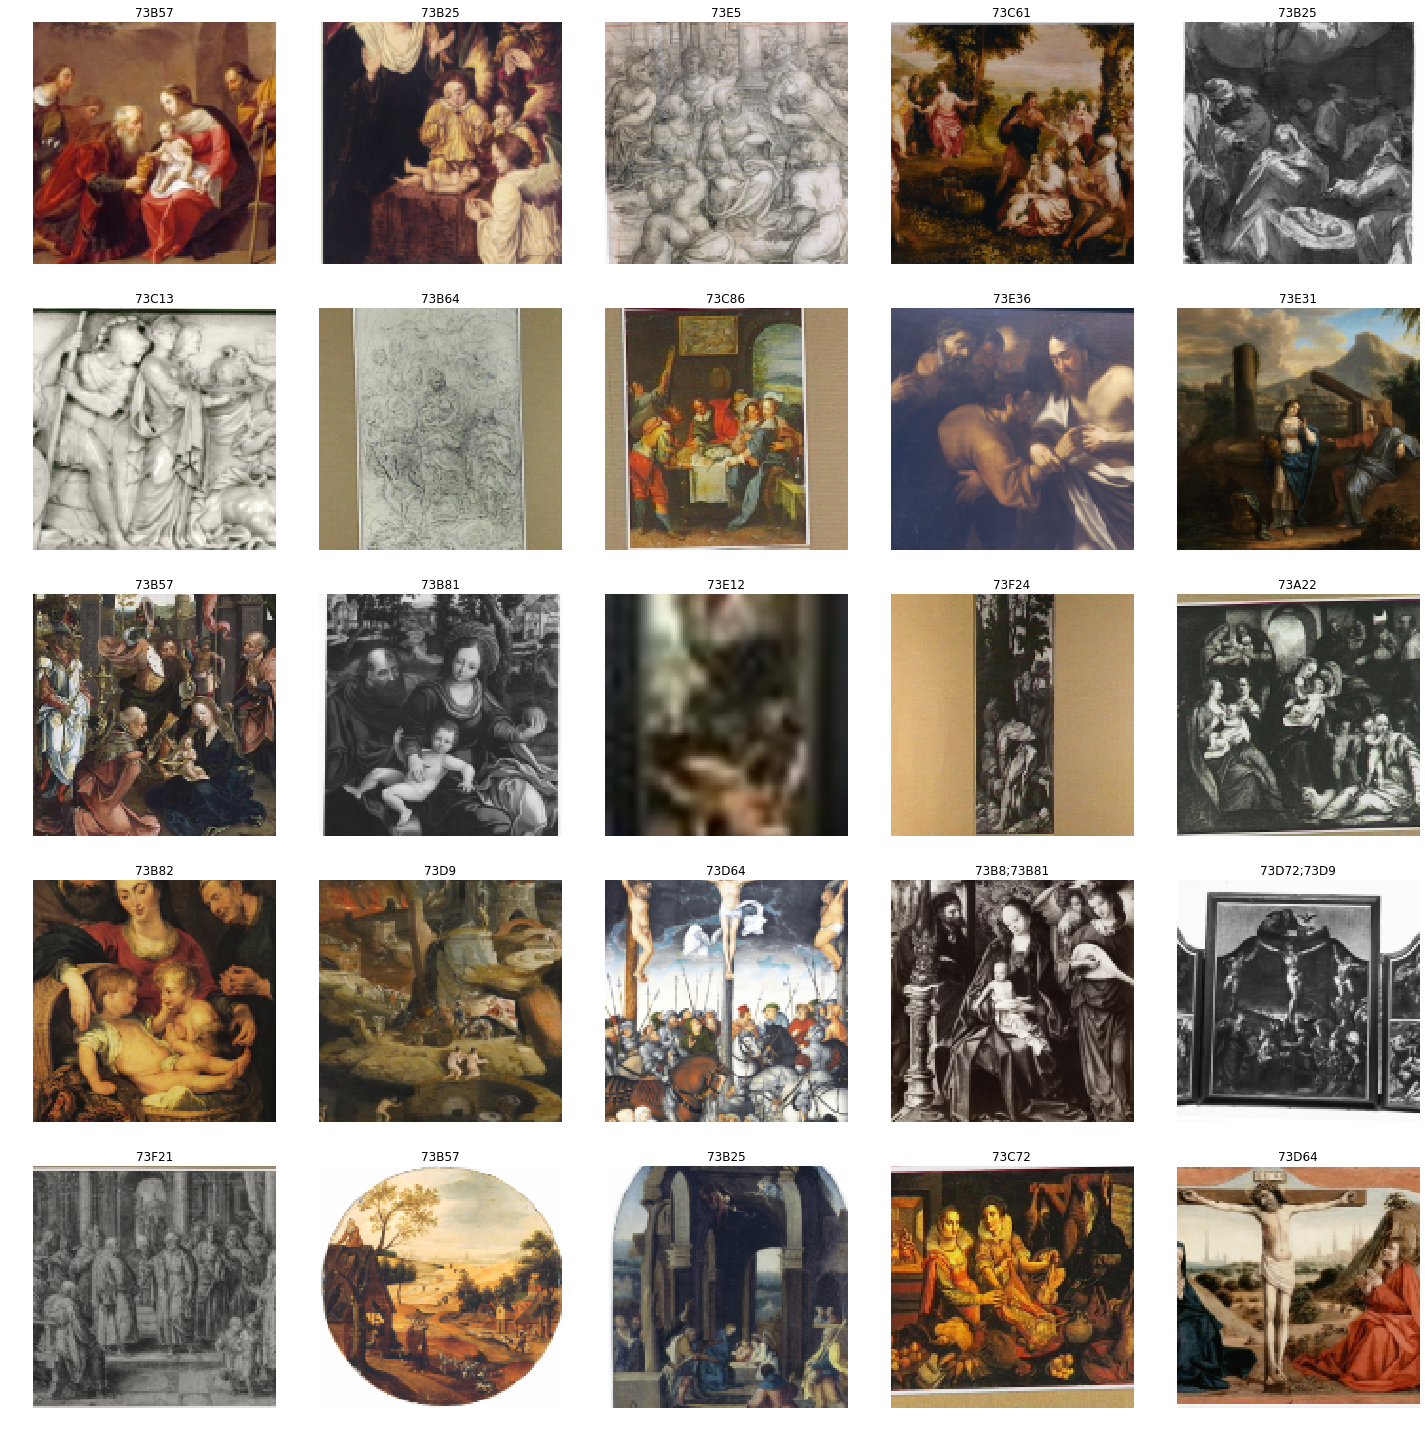

In [0]:
data.show_batch()

In [0]:
data.c

223

In [0]:
arch = models.resnet50

In [0]:
th = 0.2
acc_02 = partial(accuracy_thresh, thresh=th)
#f_score = partial(fbeta, thresh=th)
mlfb = partial(MultiLabelFbeta,thresh=th, average='micro', beta=2)

In [0]:
%cd {DRIVE_URL}
learn= load_learner('images','stage-2-best.pkl')
%cd /content

/content/drive/My Drive/gsoc_images
/content


In [0]:
learn.model[1] = create_head(num_features_model(nn.Sequential(*learn.model[0].children())) * 2,data.c).to(data.device)

In [0]:
apply_init(learn.model[1],nn.init.kaiming_normal_)

In [0]:
learn = learn.split(lambda m: (m[0][6],m[1]))

In [0]:
learn.freeze()

In [0]:
learn.data = data

In [0]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


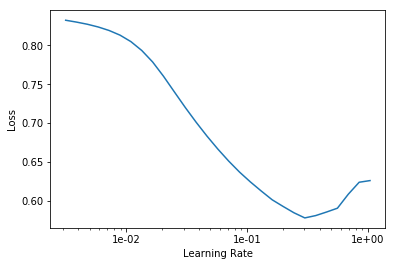

In [0]:
learn.recorder.plot(skip_start=50,skip_end=5)

In [0]:
learn.fit_one_cycle(20,slice(4e-2))

epoch,train_loss,valid_loss,accuracy_thresh,micro_fbeta,time
0,0.670079,0.342564,0.127018,0.027129,02:30
1,0.294286,0.047366,0.993676,0.059120,02:30
2,0.152912,0.037663,0.992101,0.310100,02:32
3,0.087183,0.029550,0.991911,0.415038,02:33
4,0.053201,0.031169,0.993256,0.455641,02:31
5,0.034834,0.031244,0.993300,0.481381,02:31
6,0.024590,0.031921,0.993221,0.496503,02:32
7,0.018791,0.032065,0.993397,0.498447,02:33
8,0.015314,0.032722,0.993736,0.510007,02:32
9,0.013090,0.032469,0.993449,0.524583,02:32


In [0]:
%cd {DRIVE_URL}
learn.save('RKD3_frozen_e20_f06302b256')
%cd /content

/content/drive/My Drive/gsoc_images
/content


In [0]:
%cd {DRIVE_URL}
learn.load('RKD3_frozen_e20_f06302b256')
%cd /content

/content/drive/My Drive/gsoc_images
/content


In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


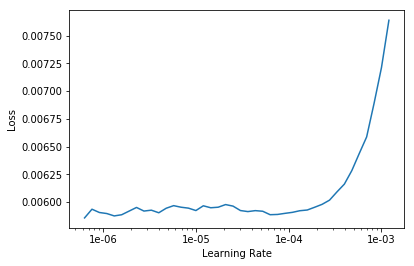

In [0]:
learn.recorder.plot(skip_end=30)

In [0]:
learn.fit_one_cycle(20,slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy_thresh,micro_fbeta,time
0,0.005946,0.034962,0.993618,0.628465,02:39
1,0.005866,0.035276,0.993585,0.635696,02:41
2,0.005835,0.035924,0.993608,0.633537,02:42
3,0.005901,0.036377,0.993606,0.633765,02:40
4,0.005998,0.036233,0.993568,0.624812,02:41
5,0.006016,0.036052,0.993607,0.627047,02:42
6,0.005974,0.035931,0.993463,0.631274,02:42
7,0.005897,0.035943,0.993340,0.632487,02:42
8,0.005707,0.036700,0.993636,0.644217,02:41
9,0.005352,0.036178,0.993645,0.658047,02:40


In [0]:
%cd {DRIVE_URL}
learn.save('RKD2_unfrozen_e20_f07051b256')
%cd /content

/content/drive/My Drive/gsoc_images
/content


In [0]:
%cd {DRIVE_URL}
learn.load('RKD2_unfrozen_e20_f07051b256')
%cd /content

/content/drive/My Drive/gsoc_images
/content


In [0]:
learn.validate()

[0.037114758, tensor(0.9939)]

In [0]:
%cd {DRIVE_URL}
learn.export('stage-3-best.pkl')
%cd /content

/content/drive/My Drive/gsoc_images
/content


In [0]:
%cd {DRIVE_URL}
learn= load_learner('images','stage-3-best.pkl')
%cd /content

/content/drive/My Drive/gsoc_images
/content


In [0]:
learn.data.c2i

{'73': 0,
 '73A11': 1,
 '73A13': 2,
 '73A14': 3,
 '73A16': 4,
 '73A18': 5,
 '73A19': 6,
 '73A2': 7,
 '73A21': 8,
 '73A22': 9,
 '73A23': 10,
 '73A3': 11,
 '73A31': 12,
 '73A32': 13,
 '73A33': 14,
 '73A34': 15,
 '73A35': 16,
 '73A41': 17,
 '73A42': 18,
 '73A5': 19,
 '73A51': 20,
 '73A52': 21,
 '73A53': 22,
 '73A56': 23,
 '73A57': 24,
 '73A6': 25,
 '73A62': 26,
 '73B': 27,
 '73B1': 28,
 '73B11': 29,
 '73B12': 30,
 '73B13': 31,
 '73B14': 32,
 '73B15': 33,
 '73B2': 34,
 '73B2(+3)': 35,
 '73B21': 36,
 '73B22': 37,
 '73B23': 38,
 '73B24': 39,
 '73B25': 40,
 '73B28': 41,
 '73B3': 42,
 '73B4': 43,
 '73B41': 44,
 '73B42': 45,
 '73B43': 46,
 '73B5': 47,
 '73B51': 48,
 '73B52': 49,
 '73B53': 50,
 '73B54': 51,
 '73B57': 52,
 '73B58': 53,
 '73B59': 54,
 '73B62': 55,
 '73B63': 56,
 '73B64': 57,
 '73B65': 58,
 '73B66': 59,
 '73B69': 60,
 '73B7': 61,
 '73B71': 62,
 '73B72': 63,
 '73B73': 64,
 '73B74': 65,
 '73B8': 66,
 '73B8(+3)': 67,
 '73B81': 68,
 '73B82': 69,
 '73B83': 70,
 '73B9': 71,
 '73B93': 72,

In [0]:
learn.data.classes

['73',
 '73A11',
 '73A13',
 '73A14',
 '73A16',
 '73A18',
 '73A19',
 '73A2',
 '73A21',
 '73A22',
 '73A23',
 '73A3',
 '73A31',
 '73A32',
 '73A33',
 '73A34',
 '73A35',
 '73A41',
 '73A42',
 '73A5',
 '73A51',
 '73A52',
 '73A53',
 '73A56',
 '73A57',
 '73A6',
 '73A62',
 '73B',
 '73B1',
 '73B11',
 '73B12',
 '73B13',
 '73B14',
 '73B15',
 '73B2',
 '73B2(+3)',
 '73B21',
 '73B22',
 '73B23',
 '73B24',
 '73B25',
 '73B28',
 '73B3',
 '73B4',
 '73B41',
 '73B42',
 '73B43',
 '73B5',
 '73B51',
 '73B52',
 '73B53',
 '73B54',
 '73B57',
 '73B58',
 '73B59',
 '73B62',
 '73B63',
 '73B64',
 '73B65',
 '73B66',
 '73B69',
 '73B7',
 '73B71',
 '73B72',
 '73B73',
 '73B74',
 '73B8',
 '73B8(+3)',
 '73B81',
 '73B82',
 '73B83',
 '73B9',
 '73B93',
 '73B94',
 '73C',
 '73C11',
 '73C12',
 '73C13',
 '73C2',
 '73C21',
 '73C22',
 '73C23',
 '73C24',
 '73C31',
 '73C32',
 '73C33',
 '73C4',
 '73C41',
 '73C42',
 '73C43',
 '73C44',
 '73C45',
 '73C46',
 '73C51',
 '73C52',
 '73C53',
 '73C61',
 '73C62',
 '73C71',
 '73C72',
 '73C73',
 '73C

In [0]:
learn.data = data

In [0]:
x = learn.data.valid_ds.x[3]

In [0]:
_, cat, prob = learn.predict(x)

In [0]:
v, i = torch.topk(prob, 3)

In [0]:
cat

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])

In [0]:
if (cat == torch.zeros(learn.data.c)).sum() == data.c:
    _,i = torch.topk(prob,3)
    pred = [data.classes[x] for x in i]
elif cat.sum().type(torch.LongTensor) < (prob > .2).sum():
    pred = [classes[i] for i,x in enumerate(prob > .2) if x == 1]
else:
    pred = [classes[i] for i,x in enumerate(cat) if x == 1]

In [0]:
cat.sum().type(torch.LongTensor) < ((prob > .2).sum())

tensor(1, dtype=torch.uint8)

In [0]:
pred

['73B83', '73B82', '73B65']

In [0]:
learn.data.valid_ds.y[3]

MultiCategory 73B83

In [0]:
i

tensor([70, 69, 58])

In [0]:
prob > .2

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)

In [0]:
v

tensor([0.4323, 0.3562, 0.0242])

In [0]:
probs, cats = learn.get_preds()

In [0]:
ys = learn.data.valid_ds.y

In [0]:
k = probs > 0.2

In [0]:
probs[0][120]

tensor(5.5338e-05)

In [0]:
k[0],probs[0],ys[0]

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8),
 tensor([8.1529e-06, 1.7690e-03, 9.1333e-06, 5.4996e-04, 2.5224e-05, 2.5406e-05,
         2.5329e-05, 1.5786e-06, 6.3502e-06, 3.9654e-04, 1.4506e-04, 1.9778e-05,
         4.6141e-04, 3.8600e-07, 3.3073e-06, 2.2520e-05, 2

In [0]:
for i in range(1,100):
    yhats =probs > i/10